### ECON 323 Final Project: How are after-school activities related to arrests in NYC?
By Felipe Grosso  
Econ 323 Spring 2021  
Prof. Peifan Wu  
TA Jan Rosa


## Introduction
 
For my final project, I want to explore two datasets from New York: a crime dataset with every arrest effected in NYC by the NYPD during the current yeara, and a after-school programs dataset from NYC. My goal with this project is fourfold: (1) show that I understand how to clean data by performing data-wrangling in these two datasets, (2) visualize essential relationships in both datasets using seaborn, (3) create a geographical interactive visualization plotting juvenile arrests and  after-school education activities in NYC, and finally, (4) propose an analysis using a determinsitic form of hierarchical clustering on the locations of felonies within the Bronx. Specifically, for (3), I want to analyze if there is a correlation between juvenile crime rates and after-school activities. I hypothesize that the more after-school activities a location had, the less juvenile arrests that location will have.  
  
Let's jump into the data. 

##### Datasets:
1. After school activities in NYC - https://data.cityofnewyork.us/Education/DYCD-after-school-programs/mbd7-jfnc
2. Arrest dataset in NYC - https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc

### Imports 

In [5]:
pip install plotly

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=7ceae92782aaca9ff8ae7b4c70d42ee8f6cd80279bfc414a2a7a2b5ab650bc4e
  Stored in directory: c:\users\felipe grosso\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import plotly as px
import datetime
from datetime import date
import math
from random import sample 
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors.nearest_centroid import NearestCentroid
sns.set(rc={'figure.figsize':(12,10)})
sns.set(style="white", context="talk")
%matplotlib inline

### Cleaning the Crime Dataset

Here I found many columns that I don't need for my analysis. Thus, I drop the columns I won't use and I create some 'code to meaning' functions to have a clearer dataset. 

In [19]:
crime_dataset = pd.read_csv(r"C:\Users\Felipe Grosso\Desktop\NYPD_Arrest_Data__Year_to_Date_ (1).csv")
crime_dataset.head(5)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,220756993,11/19/2020,155.0,RAPE 2,104.0,RAPE,PL 1303001,F,B,41,0,18-24,M,BLACK,1013232,236725,40.816392,-73.895296,POINT (-73.89529641399997 40.816391847000034)
1,220422940,11/12/2020,157.0,RAPE 1,104.0,RAPE,PL 1303502,F,Q,112,0,25-44,M,BLACK,1025420,202485,40.722364,-73.851474,POINT (-73.85147389399998 40.72236368700004)
2,218804160,10/06/2020,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,M,7,2,25-44,M,BLACK,988708,200317,40.716508,-73.983920,POINT (-73.98391989899994 40.71650772200008)
3,218641095,10/02/2020,594.0,OBSCENITY 1,116.0,SEX CRIMES,PL 2631600,F,M,5,0,25-44,M,WHITE,984946,200203,40.716196,-73.997491,POINT (-73.99749074599998 40.716195914000025)
4,217890704,09/16/2020,155.0,RAPE 2,104.0,RAPE,PL 1303001,F,K,77,0,25-44,M,WHITE HISPANIC,1003606,185050,40.674583,-73.930222,POINT (-73.93022154099998 40.67458330800008)


As we can see, the dataset is somewhat difficult to read so let's create some functions and manipulate the dataset to make it better for our analysis

In [20]:
# create functions to clean our crime dataset
def race_to_lower(race):
    """Transforms the race column into a lower-case, more legible format"""
    
    race_dictionary = {'BLACK': 'Black', 'WHITE': 'White', 'WHITE HISPANIC': "White hispanic", 'BLACK HISPANIC': 'Black hispanic', 'ASIAN / PACIFIC ISLANDER': 'Asian', 'UNKNOWN': 'Unknown','AMERICAN INDIAN/ALASKAN NATIVE': 'American Indian'}
    return race_dictionary[race]
    
def letter_to_sex(sex):
    """Connects the letter of the sex (it's identifying code) to it's corresponding sex"""
    
    sex_dictionary = {'M': 'Male', 'F': 'Female'}
    return sex_dictionary[sex]
    
def letter_to_borough(borough):
    """Connects the letter of the borough (it's identifying code) to its corresponding borough name."""
    
    borough_dictionary = {'B': 'Bronx', 'S': 'Staten Island', 'K': 'Brooklyn', 'M': 'Manhattan' , 'Q': 'Queens'}
    return borough_dictionary[borough]

def letter_to_category(category):
    """Connects the letter of the reason why the arrest was made (it's identifying code) to its corresponding category."""
    
    category_dict = {'F': 'Felony','M': 'Misdemeanor', 'V': 'Violation', 'I': 'Other'}
    if category in category_dict:
        return category_dict[category]
    else:
        return 'Other'

In [21]:
# rename columns in the crime_dataset to have an easier way of accesing data
crime_dataset.rename(columns={"ARREST_BORO": "Borough", "PD_DESC": "Felony_description",  "AGE_GROUP": "Age_group", "LAW_CAT_CD": "Crime_category", "PERP_RACE": "Race", 'PERP_SEX': 'Sex'}, inplace = True)
crime_dataset.head()

# we leave only the relevant columns for our analysis
crime_dataset = crime_dataset[['Borough','Felony_description','Age_group', 'Latitude', 'Longitude', 'Crime_category', 'Race', 'Sex']]

In [22]:
# apply the functions we created above to clean the data and make the strings more legible
crime_dataset['Race'] = crime_dataset['Race'].apply(race_to_lower)
crime_dataset['Sex'] = crime_dataset['Sex'].apply(letter_to_sex)
crime_dataset['Crime_category'] = crime_dataset['Crime_category'].apply(letter_to_category)
crime_dataset['Borough'] = crime_dataset['Borough'].apply(letter_to_borough)

In [23]:
# we end up with the following dataset
crime_dataset.head()

,Borough,Felony_description,Age_group,Latitude,Longitude,Crime_category,Race,Sex
0,Bronx,RAPE 2,18-24,40.816392,-73.895296,Felony,Black,Male
1,Queens,RAPE 1,25-44,40.722364,-73.851474,Felony,Black,Male
2,Manhattan,RAPE 1,25-44,40.716508,-73.983920,Felony,Black,Male
3,Manhattan,OBSCENITY 1,25-44,40.716196,-73.997491,Felony,White,Male
4,Brooklyn,RAPE 2,25-44,40.674583,-73.930222,Felony,White hispanic,Male


## Cleaning the After-school Activities Dataset

With the after-school activities dataset, I had to do a lot of data-cleaning. Firstly, most of the rows (except for 20) contain coordinate values in column 'Location 1'. However, upon further examination, I found that the coordinates from the columns of 'Langitude' and 'Longitude' are more accurate than the coordinates values in 'Location 1' column. Thus, I will use the values from those two columns instead of the 'Location 1' column. However, for those rows that have no 'Latitude' and 'Longitude' values, the coordiantes values in 'Location 1' are accurate enough.

In [24]:
school_dataset = pd.read_csv(r"C:\Users\Felipe Grosso\Desktop\DYCD_after-school_programs.csv")
school_dataset.tail(5)

,PROGRAM TYPE,PROGRAM,SITE NAME,BOROUGH / COMMUNITY,AGENCY,Contact Number,Grade Level / Age Group,Location 1,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
1594,"Reading & Writing,NDA Programs,English Languag...",Adult Literacy,"African Services Committee, Inc.",New York,"African Services Committee, Inc.",(212) 222-3882,16+,"429 127 Street10027\n(40.81296777641, -73.9537...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1595,"Family Support,NDA Programs",Fatherhood Initiative,Forestdale at Forest Hills Campus,Queens,"Forestdale, Inc",718.263.0740,16 to 24,"67 35 112 Street11375\n(40.72070726303, -73.84...",11375.0,40.729354,-73.842599,6.0,29.0,747.0,4441126.0,4.022060e+09,Forest Hills ...
1596,"After-School Programs,NDA Programs,Youth Educa...",High-School Aged Youth,Henry Street Settlement's Helen Hall Youth Center,New York,CCCS South Bronx Center,(212) 766-9200,High School,"301 Henry Street10002\n(40.71399949306, -73.98...",10002.0,40.714054,-73.982797,3.0,1.0,202.0,1003737.0,1.002880e+09,Lower East Side ...
1597,After-School Programs,Out of School Time,P.S. 188 KINGSBURY SCHOOL,Queens,The Child Center of New York (QCG),(917) 459-4417,Elementary,"218 12 HARTLAND AVENUE11364\n(40.74592468038, ...",11364.0,40.736177,-73.753159,11.0,23.0,129104.0,4164350.0,4.077740e+09,Oakland Gardens ...
1598,"After-School Programs,Summer Program,Summer Camp",Out of School Time,C.E.S./C.I.S. 218 RAFAEL HERNA,Bronx,Women's Housing and Economic Development Corpo...,(718) 839-1184,OST,"1220 Gerard Avenue10452\n(40.835751715972, -73...",10452.0,40.835847,-73.920026,4.0,16.0,197.0,2097130.0,2.024800e+09,West Concourse ...


In [25]:
# again, we start by creating functions to clean our dataframe
def program_type_clean(program):
    """Cleans the PROGRAM TYPE column by connecting the types of programs to the general category of the program."""
    
    program_dict = {'After-School Programs': 'School Program',
                 'After-School Programs,Jobs & Internships,Youth Employment': 'Employment Program',
                 'After-School Programs,NDA Programs,Youth Educational Support': 'School Program',
                 'Reading & Writing,NDA Programs,Family Literacy': 'Family Support Program',
                 'Family Support,NDA Programs': 'Family Support Program',
                 'Family Programs': 'Family Support Program',
                 'Immigration Services,Immigrant Support Services': 'Immigrant Support Program',
                 'Runaway & Homeless Youth': 'Youth Support Program',
                 'Immigration Services,Immigrant Support Services,NDA Programs,NDA Immigrants': 'Immigrant Support Program',
                 'Jobs & Internships': 'Employment Program',
                 'After-School Programs,Beacon,NYCHA Community Center': 'School Program',
                 'Jobs & Internships,Youth Employment': 'Employment Program',
                 'After-School Programs,NDA Programs,Adolescent Literacy,Youth Educational Support': 'Youth Support Program',
                 'NDA Programs,Senior Programs,Older Adult Program': 'Senior Support Program',
                 'After-School Programs,Summer Program,Summer Camp': 'Summer School Program',
                 'Reading & Writing,NDA Programs,English Language Program,ESOL,Family Literacy': 'Family Support Program',
                 'NDA Programs,Immigration Services,Immigrant Support Services': 'Immigrant Support Program',
                 'Reading & Writing,NDA Programs,English Language Program,Family Literacy,Adult Basic Education,ABE/GED': 'Immigrant Support Program',
                 'Reading & Writing,NDA Programs,English Language Program,ESOL,Family Literacy,Adult Basic Education,ABE/GED': 'Immigrant Support Program'}
    if program in program_dict:
        return program_dict[program]
    else:
        return 'Unclear'
    
def address_cleaner(addr):
    """Returns a cleaner and easy to understand adress string by adding spaces between the adress and the zip code."""
    
    # join strings 
    addr = " ".join(addr)
    
    # add whitespace between zip code and the adress
    addr = f'{addr[:-3]} {addr[-3:]}'
    
    return addr

def school_dataset_heat_map_enabler(coord, og_lat, og_lon):
    """Converts the lat/lon values as floats and populates NaN values from Location 1 column"""
    
    # convert our latitude and longitude strings to floats:
    lat_via_loc, lon_via_loc = coord[1:-1].split(', ')
    lat_via_loc = float(lat_via_loc)
    lon_via_loc = float(lon_via_loc)
    
    # if lat or lon dne, populate from other column
    if np.isnan(og_lat) or np.isnan(og_lon):
        return lat_via_loc, lon_via_loc  
    else:
        return og_lat, og_lon

def merge_enabler_and_cleaner(df):
    """Mixes the output between both of the functions above to return the list of addr, lat and lon coords we want."""
    
    addre, lats, lons = [], [], []
    
    for tup in df.itertuples():
        
        *addr, coord = tup.Location_Address.split('\n')
        addre.append(address_cleaner(addr))
        lat, lon = school_dataset_heat_map_enabler(coord, tup.Latitude, tup.Longitude)
        lats.append(lat)
        lons.append(lon)
        
    return addre, lats, lons

In [26]:
# rename columns
columns_rename_map = {"BOROUGH / COMMUNITY": "Borough", "PROGRAM TYPE": "Program_type", "PROGRAM": "Program", "SITE NAME": "Site_name", "Location 1": 'Location_Address'}
school_dataset.rename(columns=columns_rename_map, inplace = True)

# drop duplicates and NaNs
school_dataset.dropna(subset=['Location_Address'], inplace=True)

# filter only New-York city boroughs
school_dataset = school_dataset[school_dataset['Borough'].isin(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'])]

# remove unnecessary columns
school_dataset = school_dataset[['Program_type', 'Program', 'Site_name', 'Borough', 'Location_Address', 'Latitude', 'Longitude']]

In [27]:
# apply functions
school_dataset['Program_type'] = school_dataset['Program_type'].apply(program_type_clean)
addre, lats, lons = merge_enabler_and_cleaner(school_dataset)

school_dataset['Address'] = addre
school_dataset['Latitude'] = lats
school_dataset['Longitude'] = lons

# drop duplicates and change order of columns
school_dataset.drop_duplicates(subset = ['Latitude','Longitude'], inplace=True)
school_dataset = school_dataset[['Program_type', 'Program', 'Site_name', 'Borough', 'Address', 'Latitude', 'Longitude']]

In [28]:
school_dataset.tail()

,Program_type,Program,Site_name,Borough,Address,Latitude,Longitude
1585,Summer School Program,Out of School Time,Mitchel Center - ELEM.,Bronx,210 Alexander Avenue10 454,40.809172,-73.925777
1586,Summer School Program,Out of School Time,P.S. 124 YUNG WING SCHOOL,Manhattan,40 Division Street10 002,40.714203,-73.995797
1587,Senior Support Program,Seniors,Aquinas Housing for Seniors,Bronx,975 Tremont Avenue10 460,40.841076,-73.882280
1588,School Program,Out of School Time,Wildcat Academy HS,Bronx,1239 Lafayette Avenue10 474,40.816503,-73.890071
1595,Family Support Program,Fatherhood Initiative,Forestdale at Forest Hills Campus,Queens,67 35 112 Street11 375,40.729354,-73.842599


## Visualizations for each Datasets

Now I would like to visualize the data espoused in both datasets by providing some interactive graphs using Bokeh. Hopefully, we'll able to see and scrutinize the composition of arrests and after-school activities in NYC in a clearer fashion.  
Firstly, I will create an interactive graph for the crime dataset. 

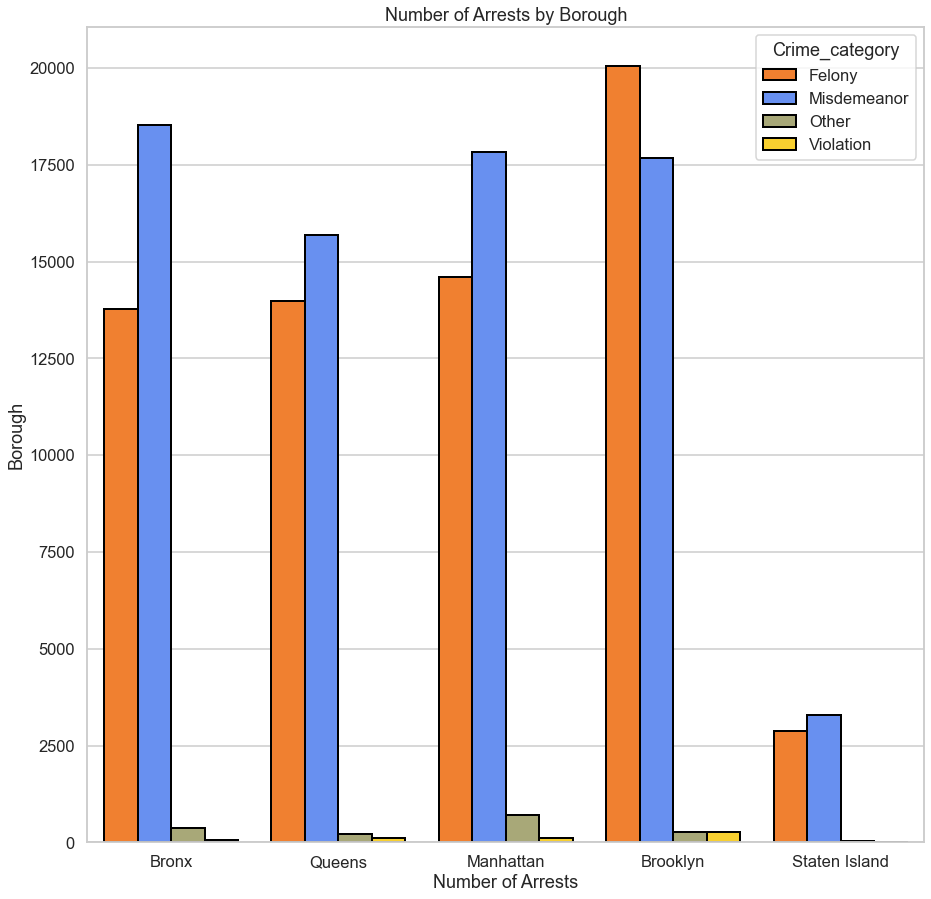

In [29]:
sns.set_style('whitegrid')
pkmn_type_colors = ['#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8A878',  # Normal
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                   ]
f, ax = plt.subplots(figsize=(15, 15))
sns.countplot(x="Borough", 
                  data=crime_dataset, 
                  hue = "Crime_category", 
                  saturation = 1, 
                  edgecolor=(0,0,0), 
                  linewidth=2, 
                  palette=pkmn_type_colors);
f, ax.set(ylabel = "Borough", xlabel = "Number of Arrests");
f, ax.set_title("Number of Arrests by Borough");

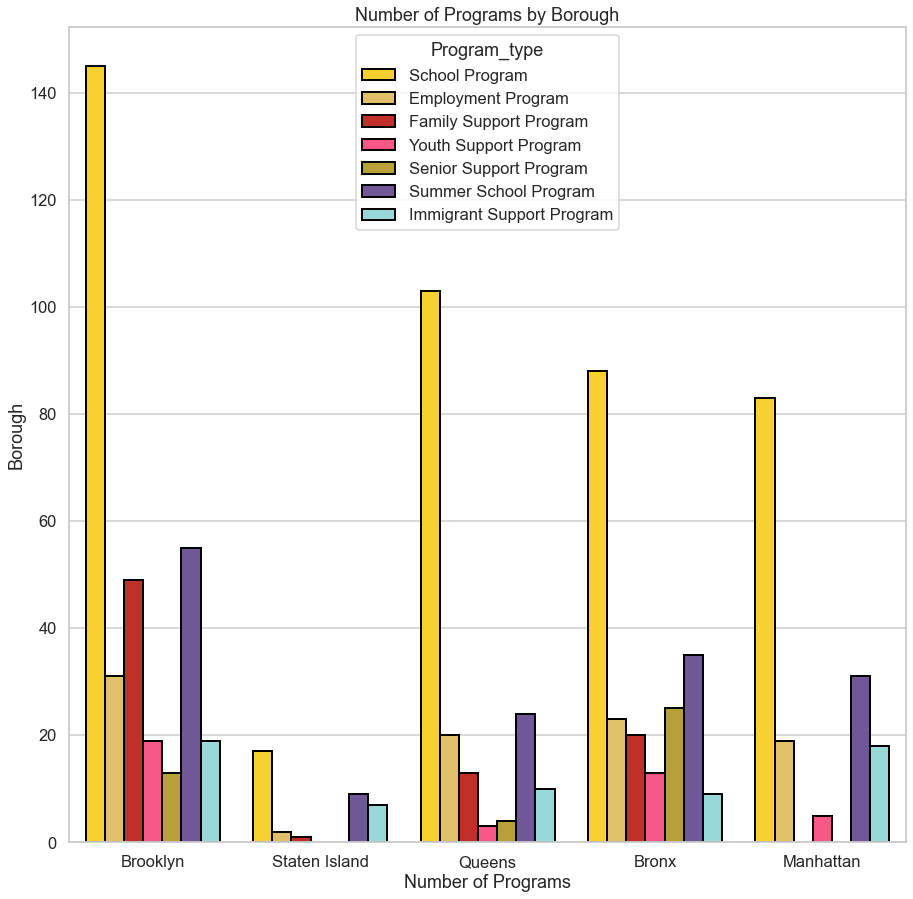

In [30]:
sns.set_style('whitegrid')
pkmn_type_colors = ['#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                   ]
f, ax = plt.subplots(figsize=(15, 15))
sns.countplot(x="Borough", 
                  data=school_dataset, 
                  hue = "Program_type", 
                  saturation = 1, 
                  edgecolor=(0,0,0), 
                  linewidth=2, 
                  palette=pkmn_type_colors);
f, ax.set(ylabel = "Borough", xlabel = "Number of Programs");
f, ax.set_title("Number of Programs by Borough");

## Map Visualizations with both Datasets

Now, for the most important aspect of my project, I want to depict the relationship between crime and after-school activities. To do so, I have created a map with all of the crimes and after-school activities by Borough. One difficulty that I faced is that, if I have too many data points in my graph, my serve crashes. Thus, I've had to restrict my analysis of the map to juvenile crimes first (18 or younger), then middle aged crimes (20-30 year olds), and finally older aged crimes (30

In [31]:
# create a list of children (<18 Age_group) crime location-tuples
arrest_18_df = crime_dataset[(crime_dataset['Age_group']=='<18')]
arrest_18_locations = list(zip(arrest_18_df['Latitude'], arrest_18_df['Longitude']))

# create a list of after-scholl activity location-tuples
edu_positions = list(zip(school_dataset['Latitude'], school_dataset['Longitude']))  # create a list of locations (tuples)

# create folium map centerd on the average location of crimes
fol = folium.Map(np.mean(arrest_18_locations, axis=0), zoom_start=10, tiles = 'Stamen Terrain')  

# create Heatmap of crime locations
HeatMap(arrest_18_locations, radius = 8).add_to(fol)

# add circles to denote after-school activity locations
[folium.Circle(pos, radius=200, color='red', fill=True, fill_opacity = 0.01, weight=0.4).add_to(fol) for pos in edu_positions]

fol

## Hierarchical Clustering Algorithmin Analysis

Now, for my analysis I will implement a deterministic form of hierarchal clustering on the locations of felonies within the Bronx. The principle assumption of this analysis is that there is an inherent structure to the distribution of crime locations. To test this assumption, I've chosen to implement a simple analysis to study the effect of age groups on this inherent structure. Given that there are five different age groups, I have chosen to group the locations of crime into 5 distinct clusters. Finally, I map the centroids of these clusters with a heat map of crimes categorized by age group. Why do this? To scrutinize whether the centroids of these clusters visually map onto the density of arrests grouped by age in the Bronx. Essentially, I want to see if there's a correlation between the spatial distribution of crimes and different age groups. 

Thus, we can conclude that: (1) age on its own, is not enough to predict the location of felonies, and (2) there appear to be outliers in the dataset where crimes that supposedly happened in the Bronx happened in other boroughs. We were hoping that the cluster centroids (in black) have the maximum color in the above color gradients (darkblue, darkgreen, brown, red, or black). However, this is not as clear at first glance. Future analysis could include race as an additional variable to consider in the centroids. Specifically, with more computing power, you could have a centroid for each race and each age group (for each borough). This would create a visual analysis of the clusters and the remaining categories, while shedding light on potentially at risk groups; for example, if you know that in a certain location, white males under the age of 18 commit more crimes, a city planner could propose tailored programs for this demographic and thus improve welfare in the beautiful city of New York. Those parameters can change. Namely, if you know that in a certain location black hispanics over the age of 65 commit more crimes, then again, you can create programs to improve the welfare of such demographic

In [32]:
~/.ipython/profile_default

SyntaxError: invalid syntax (<ipython-input-32-43d303f7c603>, line 1)

In [33]:
{notebook_directory}/.ipynb_checkpoints/

SyntaxError: invalid syntax (<ipython-input-33-3099a102ace0>, line 1)